In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from fbprophet import Prophet

In [3]:
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
sales_df = pd.read_csv('train.csv') #read training file

In [5]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False


In [6]:
sales_df.tail() #sales_df contains many stores and depts in the dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,9/28/2012,508.37,False
421566,45,98,10/5/2012,628.10,False
421567,45,98,10/12/2012,1061.02,False
421568,45,98,10/19/2012,760.01,False
421569,45,98,10/26/2012,1076.80,False


In [7]:
# Get timeseries for one store & dept. Only getting date and weekly_Sales info here as fbprophet only 
## needs date and value to forecast. Holiday data will be used as separate dataframe

df = sales_df[(sales_df['Store']==1)&(sales_df['Dept']==1)][['Date', 'Weekly_Sales']] 

In [8]:
df.head()

,Date,Weekly_Sales
0,2/5/2010,24924.50
1,2/12/2010,46039.49
2,2/19/2010,41595.55
3,2/26/2010,19403.54
4,3/5/2010,21827.90


In [9]:
df.tail()

,Date,Weekly_Sales
138,9/28/2012,18947.81
139,10/5/2012,21904.47
140,10/12/2012,22764.01
141,10/19/2012,24185.27
142,10/26/2012,27390.81


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null object
Weekly_Sales    143 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [11]:
df['Date'] = pd.DatetimeIndex(df['Date']) #convert date to date datatype

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null datetime64[ns]
Weekly_Sales    143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [13]:
df = df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet

In [14]:
df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [15]:
orig_df = df.copy()

In [16]:
#orig_df

In [17]:
df['y'] = np.log(df['y'])

In [18]:
df.head()

,ds,y
0,2010-02-05,10.123607
1,2010-02-12,10.737255
2,2010-02-19,10.635748
3,2010-02-26,9.873211
4,2010-03-05,9.990944


In [19]:
# Visualize the data

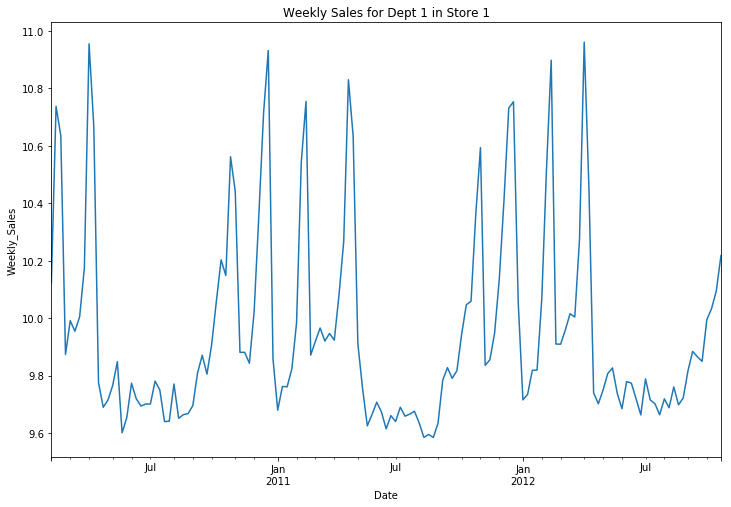

In [20]:
df.set_index('ds').y.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.title('Weekly Sales for Dept 1 in Store 1');

In [21]:
## Get the holiday info for Store 1, Dept 1
sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [22]:
holiday_dates = sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

In [23]:
holiday_dates

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [24]:
holiday_dates['Date'].values

array(['2/12/2010', '9/10/2010', '11/26/2010', '12/31/2010', '2/11/2011',
       '9/9/2011', '11/25/2011', '12/30/2011', '2/10/2012', '9/7/2012'], dtype=object)

In [25]:
## Create holiday df with lower and upper window = 0, as we do not want to extend the holiday out
# to days around the given date

presidentsday_df = pd.DataFrame({
    'holiday': 'PresidentsDay',
    'ds': pd.to_datetime(['2/12/2010','2/11/2011','2/10/2012']),
    'lower_window': 0,
    'upper_window': 0
})

laborday_df = pd.DataFrame({
    'holiday': 'LaborDay',
    'ds': pd.to_datetime(['9/10/2010','9/9/2011','9/7/2012']),
    'lower_window': 0,
    'upper_window': 0
})

thanksgiving_df = pd.DataFrame({
    'holiday': 'LaborDay',
    'ds': pd.to_datetime(['11/26/2010','11/25/2011']),
    'lower_window': 0,
    'upper_window': 0
})

newyears_df = pd.DataFrame({
    'holiday': 'NewYearDay',
    'ds': pd.to_datetime(['12/31/2010','12/30/2011']),
    'lower_window': 0,
    'upper_window': 0
})


In [26]:
holidays_df = pd.concat((presidentsday_df, laborday_df, thanksgiving_df, newyears_df))

In [27]:
holidays_df

,ds,holiday,lower_window,upper_window
0,2010-02-12,PresidentsDay,0,0
1,2011-02-11,PresidentsDay,0,0
2,2012-02-10,PresidentsDay,0,0
0,2010-09-10,LaborDay,0,0
1,2011-09-09,LaborDay,0,0
2,2012-09-07,LaborDay,0,0
0,2010-11-26,LaborDay,0,0
1,2011-11-25,LaborDay,0,0
0,2010-12-31,NewYearDay,0,0
1,2011-12-30,NewYearDay,0,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
ds    143 non-null datetime64[ns]
y     143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [29]:
## Split train and test set 
train_df = df[:100] #split train, test into 70/30 of df
test_df = df[100:]

In [30]:
train_df.head()

,ds,y
0,2010-02-05,10.123607
1,2010-02-12,10.737255
2,2010-02-19,10.635748
3,2010-02-26,9.873211
4,2010-03-05,9.990944


In [31]:
train_df.tail()

,ds,y
95,2011-12-02,10.138302
96,2011-12-09,10.413490
97,2011-12-16,10.731450
98,2011-12-23,10.753398
99,2011-12-30,10.058390


In [32]:
test_df.head()

,ds,y
100,2012-01-06,9.715210
101,2012-01-13,9.734737
102,2012-01-20,9.818207
103,2012-01-27,9.818918
104,2012-02-03,10.065202


In [33]:
test_df.tail()

,ds,y
138,2012-09-28,9.849444
139,2012-10-05,9.994446
140,2012-10-12,10.032936
141,2012-10-19,10.093499
142,2012-10-26,10.217963


### Using Prophet

In [129]:
#del(model)
#del(forecast)

In [104]:
# include holiday effects & yearly_seasonality as our data follows yearly seasonal pattern
model = Prophet(holidays=holidays_df, yearly_seasonality=True) 
model.add_seasonality(name='yearly', period='365.25', fourier_order=7) 

In [105]:
# Fit model on train data
model.fit(train_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [106]:
# Define future timeframe, with 43 weeks, since this is the number of weeks we have in the test_df
future = model.make_future_dataframe(periods=43, freq='W-FRI') 

In [107]:
future.head()

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05


In [108]:
future.tail()

,ds
138,2012-09-28
139,2012-10-05
140,2012-10-12
141,2012-10-19
142,2012-10-26


In [109]:
# Use predict method to forecast for the future timeframe
forecast = model.predict(future)

In [110]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,LaborDay,LaborDay_lower,LaborDay_upper,NewYearDay,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
138,2012-09-28,9.942760,9.942293,9.943218,9.641380,10.083296,0.0,0.0,0.0,0.0,...,-0.076366,-0.076366,-0.076366,-0.076366,-0.076366,-0.076366,-0.076366,-0.076366,-0.076366,9.866394
139,2012-10-05,9.942552,9.942074,9.943028,9.675494,10.113795,0.0,0.0,0.0,0.0,...,-0.052889,-0.052889,-0.052889,-0.052889,-0.052889,-0.052889,-0.052889,-0.052889,-0.052889,9.889663
140,2012-10-12,9.942343,9.941841,9.942838,9.773724,10.234513,0.0,0.0,0.0,0.0,...,0.056101,0.056101,0.056101,0.056101,0.056101,0.056101,0.056101,0.056101,0.056101,9.998444
141,2012-10-19,9.942134,9.941613,9.942650,9.978505,10.415369,0.0,0.0,0.0,0.0,...,0.262671,0.262671,0.262671,0.262671,0.262671,0.262671,0.262671,0.262671,0.262671,10.204805
142,2012-10-26,9.941925,9.941385,9.942459,10.163249,10.611115,0.0,0.0,0.0,0.0,...,0.442140,0.442140,0.442140,0.442140,0.442140,0.442140,0.442140,0.442140,0.442140,10.384065


In [111]:
# Observe the yhat (predicted value) and yhat (upper, lower) for the last 5 recoords
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
138,2012-09-28,9.866394,9.641380,10.083296
139,2012-10-05,9.889663,9.675494,10.113795
140,2012-10-12,9.998444,9.773724,10.234513
141,2012-10-19,10.204805,9.978505,10.415369
142,2012-10-26,10.384065,10.163249,10.611115


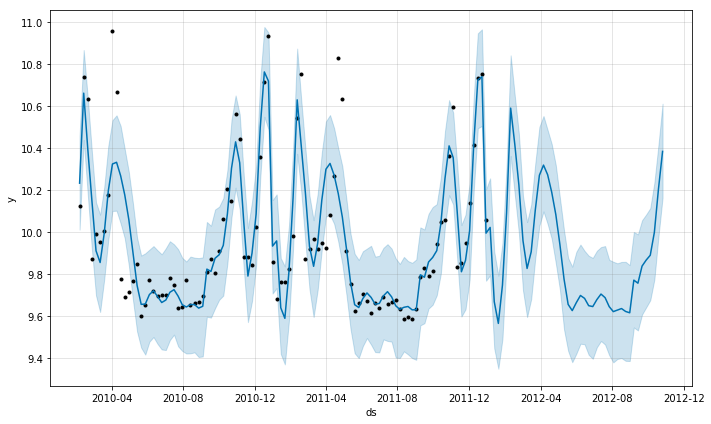

In [112]:
# Plot the forecst
model.plot(forecast);

In [113]:
#### Observed values (black dots), the forecasted values (blue line) and 
### the uncertainty intervals of our forecast(shaded blue area).

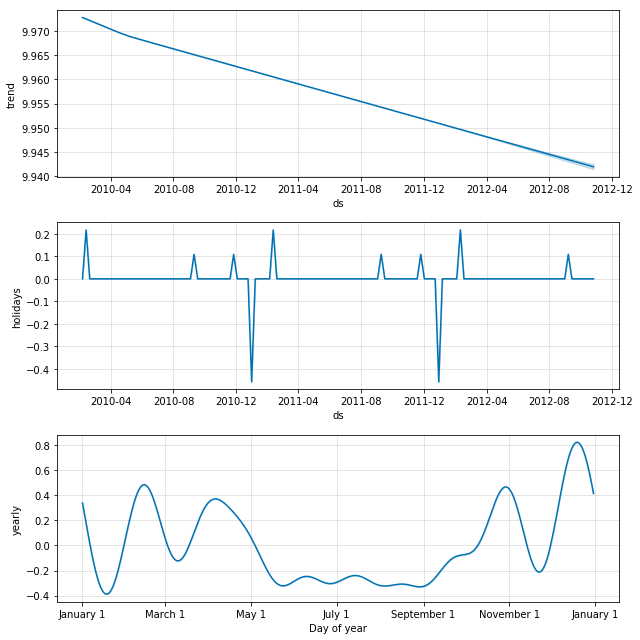

In [114]:
model.plot_components(forecast);

In [130]:
### Question: Why is th trend line going down here? Where in the original data that we see a decreasing trend?

In [115]:
y_hat = np.exp(forecast['yhat'][100:]) ## convert the forecasted log values to original scale

In [116]:
test_df.head() #get the actual sales from the hold(test) set

,ds,y
100,2012-01-06,9.715210
101,2012-01-13,9.734737
102,2012-01-20,9.818207
103,2012-01-27,9.818918
104,2012-02-03,10.065202


In [117]:
y_actual = np.exp(test_df['y']) #transform the actual values from log

In [118]:
metrics_df = np.exp(forecast.set_index('ds')[['yhat']][100:]).join(np.exp(test_df.set_index('ds').y)).reset_index()

In [119]:
metrics_df # where yhat is the predicted and y is the actual value

,ds,yhat,y
0,2012-01-06,22517.303337,16567.69
1,2012-01-13,15813.730091,16894.40
2,2012-01-20,14259.770474,18365.10
3,2012-01-27,17111.582484,18378.16
4,2012-02-03,24107.483113,23510.49
5,2012-02-10,39742.186813,36988.49
6,2012-02-17,33480.834742,54060.10
7,2012-02-24,27566.916604,20124.22
8,2012-03-02,21137.588500,20113.03
9,2012-03-09,18523.271431,21140.07


In [120]:
mean_squared_error(metrics_df.y, metrics_df.yhat)

36731099.377112746

In [121]:
mean_absolute_error(metrics_df.y, metrics_df.yhat)

3268.234398184883

In [123]:
#model.predictive_samples(future)

In [124]:
## Perform Cross validation to measure forecast error

In [125]:
df_cv = cross_validation(model, horizon='120 days')
# Computes forecasts from historical cutoff points. 
# Beginning from initial, makes cutoffs with a spacing of period up to (end - horizon).

In [126]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-03-11,9.696945,9.540954,9.883018,9.965542,2011-03-05
1,2011-03-18,9.928166,9.749171,10.096155,9.920061,2011-03-05
2,2011-03-25,10.361266,10.181914,10.529971,9.946600,2011-03-05
3,2011-04-01,10.626634,10.450873,10.805375,9.923197,2011-03-05
4,2011-04-08,10.490776,10.313620,10.673562,10.080536,2011-03-05
5,2011-04-15,10.065413,9.894505,10.231716,10.266823,2011-03-05
6,2011-04-22,9.679110,9.501659,9.861460,10.829933,2011-03-05
7,2011-04-29,9.557416,9.375374,9.737344,10.633747,2011-03-05
8,2011-05-06,9.646565,9.472524,9.826373,9.910373,2011-03-05
9,2011-05-13,9.735624,9.550972,9.907727,9.754706,2011-03-05


In [127]:
mean_squared_error(df_cv.y, df_cv.yhat)

0.061669821933416316

In [128]:
mean_absolute_error(df_cv.y, df_cv.yhat)

0.14509899862123704

In [131]:
### Question: How is that the forecast error MSE and MAE of the cross validation results are 0.06, 0.145 
### versus the forecasted to actual's MSE is 36731099.377 and MAE is 3268.2343?